In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv("/Users/lilitharutyunyan/Documents/GitHub/Compas-recidivism-analysis/data-cleaned/compas-scores-two-years-clean.csv", parse_dates=["c_jail_in", "c_jail_out"])
df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,score_text,v_type_of_assessment,v_decile_score,v_score_text,in_custody,out_custody,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-07-07,2014-07-14,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,Risk of Violence,1,Low,2013-01-26,2013-02-05,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,Risk of Violence,3,Low,2013-06-16,2013-06-16,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,High,Risk of Violence,6,Medium,NaN,NaN,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,Low,Risk of Violence,1,Low,NaN,NaN,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6211,10995,raheem smith,raheem,smith,2013-10-20,Male,1995-06-28,20,Less than 25,African-American,...,High,Risk of Violence,9,High,2014-04-07,2014-04-27,0,169,0,0
6212,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,Medium,Risk of Violence,5,Medium,2013-11-22,2013-11-24,1,860,0,0
6213,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,Low,Risk of Violence,5,Medium,2014-01-31,2014-02-02,1,790,0,0
6214,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,Low,Risk of Violence,1,Low,2014-01-13,2014-01-14,0,808,0,0


* first: An individual’s first name

* last: An individual’s last name

* sex: An individual’s sex

* age: An individual’s age

* race: An individual’s race. It takes values of Caucasian, Hispanic, African-American, Native American, Asian, or Other

* priors_count: Number of previous arrests

* decile_score: The COMPAS risk score

* two_year_recid: Whether the individual had been jailed for a new crime in next two years

# Assumptions

* I would assume that the prefixes c_*, r_* and vr_* stand for "charge", "recidivism" and "violent recidivism"
* charge_degree: We assume that the value "F" stands for Felony (serious crime) and M for misdemeanor. Is this correct? reasonable
* juv_fel_count: Is this the number of juvenile felonies of the defendant? reasonable
* juv_misd_count: Is this the number of juvenile misdemeanors of the defendant ? reasonable
* juv_other_count: What does "other" include? Should we consider it as an attribute for our model? Another factor level ?
* priors_count: Is this the number of prior felonies or misdemeanors or both and does it also include the juvenile 
* priors? Can you compare counts and see if they add up?


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6216 entries, 0 to 6215
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       6216 non-null   int64         
 1   name                     6216 non-null   object        
 2   first                    6216 non-null   object        
 3   last                     6216 non-null   object        
 4   compas_screening_date    6216 non-null   object        
 5   sex                      6216 non-null   object        
 6   dob                      6216 non-null   object        
 7   age                      6216 non-null   int64         
 8   age_cat                  6216 non-null   object        
 9   race                     6216 non-null   object        
 10  juv_fel_count            6216 non-null   int64         
 11  decile_score             6216 non-null   int64         
 12  juv_misd_count           6216 non-

# First: Transform into a binary classification problem


In [14]:
df['is_med_or_high_risk']  = (df['decile_score']>=5).astype(int)

#Any score 5 or higher (Medium or High risk) means that a defendant is treated as a likely recividist, 
# and a score of 4 or lower (Low risk) means that a defendant is treated as unlikely to re-offend.

* decile_score = risk score prediction of the COMPAS system
* is_med_or_high_risk = the classification of COMPAS as medium/high risk or low risk
* two_year_recid = The “true” recidivism value (whether or not the defendant committed another crime in the next two years)

* false positives (defendant is predicted as medium/high risk but does not re-offend)
* false negatives (defendant is predicted as low risk, but does re-offend)

In [10]:
[[tn , fp],[fn , tp]]  = confusion_matrix(df['two_year_recid'], df['is_med_or_high_risk'])
print("True negatives:  ", tn)
print("False positives: ", fp)
print("False negatives: ", fn)
print("True positives:  ", tp)

True negatives:   2681
False positives:  1282
False negatives:  841
True positives:   1412


In [11]:
fpr = fp/(fp+tn)
fnr  = fn/(fn+tp)

print("False positive rate (overall): ", fpr)
print("False negative rate (overall): ", fnr)

False positive rate (overall):  0.32349230381024474
False negative rate (overall):  0.3732800710164225


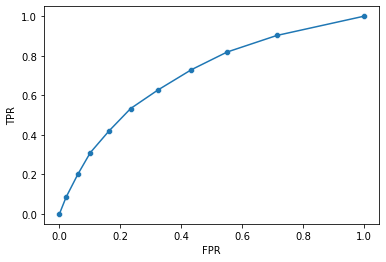

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(df['two_year_recid'], df['decile_score'])
sns.scatterplot(x=fpr, y=tpr, );
sns.lineplot(x=fpr, y=tpr);
plt.ylabel("TPR");
plt.xlabel("FPR");

* ROC curve is a performance measurement for the classification problems at various threshold settings. A ROC curve is constructed by plotting the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN)). Similarly, the false positive rate is the proportion of observations that are incorrectly predicted to be positive out of all negative observations (FP/(TN + FP)). 

In [13]:
auc = roc_auc_score(df['two_year_recid'], df['decile_score'])
auc

0.7030253435042003

* ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

# Race

In [15]:
df['race'].value_counts()

African-American    3139
Caucasian           2132
Hispanic             563
Other                340
Asian                 28
Native American       14
Name: race, dtype: int64

In [16]:
df = df[df.race.isin(["African-American","Caucasian"])]
# compare accuracy
(df['two_year_recid']==df['is_med_or_high_risk']).astype(int).groupby(df['race']).mean()

race
African-American    0.624084
Caucasian           0.689024
dtype: float64

# Linear Regression